In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# DRop education, drop number of open complaints

# Round 1 & 2

In [2]:
# Reading files
data = pd.read_csv("./files_for_lab/csv_files/marketing_customer_analysis.csv")

In [3]:
# -- Show the dataframe shape.
print(data.shape)

(10910, 26)


In [4]:
# -- Standardize header names.

# I first drop the old index column
data = data.drop(['Unnamed: 0'],axis=1)

In [5]:
# Turn everying to snake_case
data.columns = list(map(lambda x: x.lower(), data.columns))
data.columns = data.columns.str.replace(' ','_')

In [6]:
# -- Which columns are numerical?
data.select_dtypes(np.number).head(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,4809.216960,48029,61,7.0,52,0.0,9,292.800000
1,2228.525238,0,64,3.0,26,0.0,1,744.924331
2,14947.917300,22139,100,34.0,31,0.0,2,480.000000
3,22332.439460,49078,97,10.0,3,0.0,2,484.013411
4,9025.067525,23675,117,NaN,31,NaN,7,707.925645


In [7]:
# -- Which columns are categorical?
data.select_dtypes(object).head(5)

,customer,state,response,coverage,education,effective_to_date,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size,vehicle_type
0,DK49336,Arizona,No,Basic,College,2/18/11,Employed,M,Suburban,Married,Corporate Auto,Corporate L3,Offer3,Agent,Four-Door Car,Medsize,NaN
1,KX64629,California,No,Basic,College,1/18/11,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer4,Call Center,Four-Door Car,Medsize,NaN
2,LZ68649,Washington,No,Basic,Bachelor,2/10/11,Employed,M,Suburban,Single,Personal Auto,Personal L3,Offer3,Call Center,SUV,Medsize,A
3,XL78013,Oregon,Yes,Extended,College,1/11/11,Employed,M,Suburban,Single,Corporate Auto,Corporate L3,Offer2,Branch,Four-Door Car,Medsize,A
4,QA50777,Oregon,No,Premium,Bachelor,1/17/11,Medical Leave,F,Suburban,Married,Personal Auto,Personal L2,Offer1,Branch,Four-Door Car,Medsize,NaN


In [8]:
# -- Check and deal with NaN

#data[data.isna().any(axis=1)] 

# It seems we have a lot of NaNs. Most of them come from vehicle_type, we're missing 
# that data for half of the rows. Guessing NaN is manual:
data['vehicle_type']=data['vehicle_type'].fillna('M')

In [9]:
data.isna().sum()

customer                           0
state                            631
customer_lifetime_value            0
response                         631
coverage                           0
education                          0
effective_to_date                  0
employmentstatus                   0
gender                             0
income                             0
location_code                      0
marital_status                     0
monthly_premium_auto               0
months_since_last_claim          633
months_since_policy_inception      0
number_of_open_complaints        633
number_of_policies                 0
policy_type                        0
policy                             0
renew_offer_type                   0
sales_channel                      0
total_claim_amount                 0
vehicle_class                    622
vehicle_size                     622
vehicle_type                       0
dtype: int64

In [10]:
# Filling the categorical NaN with mode values
categ_nan_cols = data.select_dtypes(object).isna().sum()>0 #list of booleans
categ_nan_cols = categ_nan_cols[categ_nan_cols] #choosing only TRUE columns
categ_nan_cols = list(categ_nan_cols.index.values) #getting the column names
    
for column in categ_nan_cols:
    data[column] = data[column].fillna(data[column].mode()[0])
    
# Filling the numerical NaN with median values
num_nan_cols = data.select_dtypes(np.number).isna().sum()>0
num_nan_cols = num_nan_cols[num_nan_cols]
num_nan_cols = list(num_nan_cols.index.values)
    
for column in num_nan_cols:
    data[column]=data[column].fillna(data[column].mean())

In [11]:
# -- Datetime format - Extract the months from the dataset and store in a separate column. 
# Converting to datetime format
data['effective_to_date']=pd.to_datetime(data['effective_to_date'])

In [12]:
# Creating "month" attribute through the month_name function
data['month']=data['effective_to_date'].dt.month_name()

In [13]:
# filter only for January, February and March
data[data['month'].isin(['January','February','March'])].head(5)
# I think we only have data for Jan and Feb since the number of rows looks the same. 

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,...,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,vehicle_type,month
0,DK49336,Arizona,4809.216960,No,Basic,College,2011-02-18,Employed,M,48029,...,9,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,M,February
1,KX64629,California,2228.525238,No,Basic,College,2011-01-18,Unemployed,F,0,...,1,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,M,January
2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2011-02-10,Employed,M,22139,...,2,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A,February
3,XL78013,Oregon,22332.439460,Yes,Extended,College,2011-01-11,Employed,M,49078,...,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A,January
4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,2011-01-17,Medical Leave,F,23675,...,7,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,M,January


In [14]:
# Round 2 doesn't state it but I think we also needed to filter out
# negative and zero incomes
data = data[data['income']>0]

# Checking for duplicates
print(len(data[data.duplicated()]))

# Removing them
data = data.drop_duplicates()

# Resseting index
data = data.reset_index(drop=True)

148


# bonus function

In [15]:
# file_location = "./files_for_lab/csv_files/marketing_customer_analysis.csv"
# def bonus(file_loc):
    
#     #auxiliar function for the month extraction
#     def extract_month(date):
#         months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
#         return months[date.month-1]

#     # reading file
#     data = pd.read_csv(file_loc)
    
#     print('Printing datashape'),print(data.shape)
    
#     #dropping old index
#     data = data.drop(['Unnamed: 0'],axis=1)
    
#     #to snake_case
#     data.columns = list(map(lambda x: x.lower(), data.columns))
#     data.columns = data.columns.str.replace(' ','_')
    
#     print('\nPrinting numerical data'),print(data.select_dtypes(np.number).head(3))
#     print('\n\nPrinting categorical data'),print(data.select_dtypes(object).head(3))
    
#     # I drop this column tho I'm not sure it's the right way to approach
#     # the problem.
#     data=data.drop(['vehicle_type'],axis=1)
    
#     # Filling the categorical NaN with mode values
#     categ_nan_cols = data.select_dtypes(object).isna().sum()>0 #list of booleans
#     categ_nan_cols = categ_nan_cols[categ_nan_cols] #choosing only TRUE columns
#     categ_nan_cols = list(categ_nan_cols.index.values) #getting the column names
    
#     for column in categ_nan_cols:
#         breakpoint()
#         data[column] = data[column].fillna(data[column].mode()[0])
    
#     # Filling the numerical NaN with median values
#     num_nan_cols = data.select_dtypes(np.number).isna().sum()>0
#     num_nan_cols = num_nan_cols[num_nan_cols]
#     num_nan_cols = list(num_nan_cols.index.values)
    
#     for column in num_nan_cols:
#         data[column]=data[column].fillna(data[column].mean())
    
#     #Converting to datetime
#     data['effective_to_date']=pd.to_datetime(data['effective_to_date'])
    
#     # Creating "month" attribute through the extract_month function
#     data['month']=data['effective_to_date'].apply(extract_month)

        
#     # Finally filtering data for Jan,Feb,March
#     data = data[data['month'].isin(['January','February','March'])]

#     # Round 2 doesn't state it but I think we also needed to filter out
#     # negative and zero incomes
#     data = data[data['income']>0]
    
#     return data


# bonus(file_location)

# Round 3

In [16]:
# -- Show dataframe info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7975 entries, 0 to 7974
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer                       7975 non-null   object        
 1   state                          7975 non-null   object        
 2   customer_lifetime_value        7975 non-null   float64       
 3   response                       7975 non-null   object        
 4   coverage                       7975 non-null   object        
 5   education                      7975 non-null   object        
 6   effective_to_date              7975 non-null   datetime64[ns]
 7   employmentstatus               7975 non-null   object        
 8   gender                         7975 non-null   object        
 9   income                         7975 non-null   int64         
 10  location_code                  7975 non-null   object        
 11  marital_status   

In [17]:
# -- Describe dataframe
data.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_lifetime_value,7975.0,8147.878798,6991.141487,2119.894333,4100.028809,5800.171881,9080.053109,83325.381190
income,7975.0,50407.097931,24279.199941,10037.000000,28361.500000,48115.000000,70106.500000,99981.000000
monthly_premium_auto,7975.0,93.061567,34.682618,61.000000,68.000000,83.000000,109.000000,297.000000
months_since_last_claim,7975.0,15.095252,9.784565,0.000000,7.000000,15.000000,23.000000,35.000000
months_since_policy_inception,7975.0,47.892665,27.883145,0.000000,24.000000,48.000000,71.000000,99.000000
number_of_open_complaints,7975.0,0.381287,0.880323,0.000000,0.000000,0.000000,0.384256,5.000000
number_of_policies,7975.0,2.953730,2.397325,1.000000,1.000000,2.000000,4.000000,9.000000
total_claim_amount,7975.0,378.294164,252.207961,0.099007,213.917240,340.800000,499.200000,2893.239678


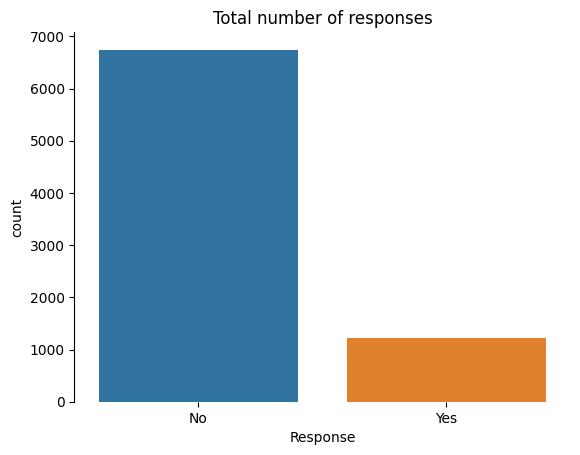

In [18]:
# -- Show a plot of the total number of responses.
sns.countplot(x = "response", data=data)

# Changing graph style
sns.despine(bottom = True, left = False)
plt.title('Total number of responses')
plt.xlabel('Response')
plt.show()

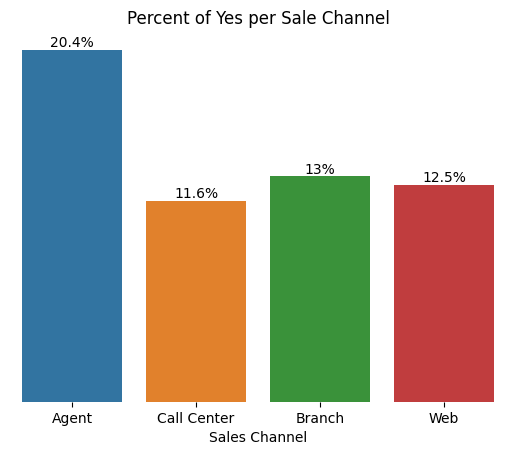

In [19]:
# -- Show a plot of the response rate by the sales channel.

# I want it to show percentages to compare between channels, because we don't have the 
# same number of data for each category. As Erin did, I'll create a new binary column. 
aux = np.where(data.response == 'Yes',1,0)*100 # I multiply *100 so I get a %
ax = sns.barplot(x='sales_channel',y=aux,data=data,errorbar=None) 

# Changing graph style
sns.despine(bottom = True, left = True)
ax.bar_label(ax.containers[0], fmt='%.3g%%')
plt.tick_params(labelleft=False, left=False)
plt.title('Percent of Yes per Sale Channel')
plt.xlabel('Sales Channel')
plt.show()

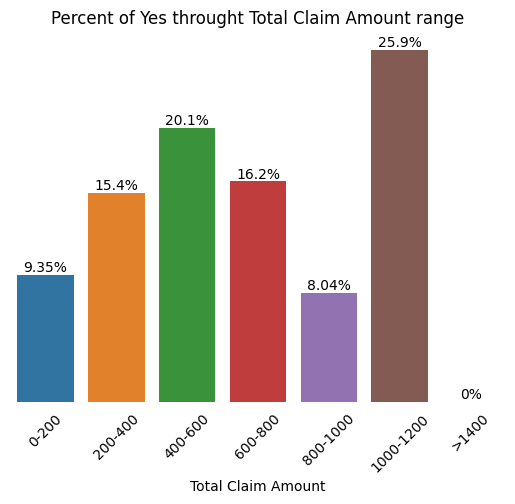

In [20]:
# -- Show a plot of the response rate by the total claim amount.

# Before being able to plot it we need to bin total claim amount. 
# I tried to make a general binning function. 

# ------------------------------------------------------------- #
def binning(data_column,bins,threshold=0,decimals=None):
#     This function returns a series and an order list. It replaces
#     each value of data_column by the name of the bin said value 
#     falls in. The number of bins is given by "bins", and threshold
#     is a optional paramater to stop the binning there and make a last
#     bin for values bigger than threshold. 
    new_column = data_column.copy()
    order = []
    # Calculating the range of the column and the column bins
    if threshold == 0:
        cmax,cmin = max(data_column),min(data_column)
        cbins = list(np.arange(cmin,cmax+1,(cmax-cmin)/bins))
    else:
        cmax,cmin = threshold,min(data_column)
        cbins = list(np.arange(cmin,cmax+1,(cmax-cmin)/bins))   
    
    # Iterating for each row and replacing its value by its bin
    if threshold == 0:
        for record in range(len(data_column)):
            for bin in cbins[1:]:
                if data_column[record] <= bin:
                    new_column[record] = str(round(cbins[cbins.index(bin)-1],decimals))+'-'+str(round(cbins[cbins.index(bin)],decimals))
                    break
    else:
        for record in range(len(data_column)):
            for bin in cbins[1:]:
                if data_column[record] <= bin:
                    new_column[record] = str(round(cbins[cbins.index(bin)-1],decimals))+'-'+str(round(cbins[cbins.index(bin)],decimals))
                    break
                new_column[record] = ">"+str(int(cbins[-1]))
    
    # Creating list with the order of the bins
    if threshold != 0:
        for bin in cbins[1:-1]:
            order.append(str(round(cbins[cbins.index(bin)-1],decimals))+'-'+str(round(cbins[cbins.index(bin)],decimals)))
        order.append(">"+str(round(cbins[-1],decimals)))
    else:
         for bin in cbins[1:]:
            order.append(str(round(cbins[cbins.index(bin)-1],decimals))+'-'+str(round(cbins[cbins.index(bin)],decimals)))
    return new_column, order 
# ------------------------------------------------------------- #

tca_bin,order = binning(data['total_claim_amount'],bins=7,threshold=1400)
aux = np.where(data.response == 'Yes',100,0) # I use 100 instead of 1 to get a %.
ax = sns.barplot(x=tca_bin,y=aux,data=data,errorbar=None,order=order) 
plt.xticks(rotation = 45)

# Changing graph style
sns.despine(bottom = True, left = True)
ax.bar_label(ax.containers[0], fmt='%.3g%%')
plt.tick_params(labelleft=False, left=False)
plt.title('Percent of Yes throught Total Claim Amount range')
plt.xlabel('Total Claim Amount')
ax.xaxis.set_ticks_position('none') 

plt.show()


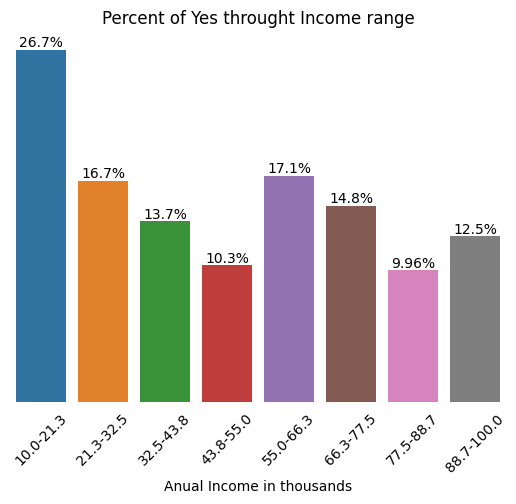

In [21]:
# -- Show a plot of the response rate by income.
inc_bin,order = binning(data['income']/1000,bins=8,decimals=1)
aux = np.where(data.response == 'Yes',100,0) # I use 100 instead of 1 to get a %.
ax = sns.barplot(x=inc_bin,y=aux,data=data,errorbar=None,order=order) 

# Changing graph style
sns.despine(bottom = True, left = True)
ax.bar_label(ax.containers[0], fmt='%.3g%%')
plt.tick_params(labelleft=False, left=False)
plt.title('Percent of Yes throught Income range')
plt.xlabel('Anual Income in thousands')
ax.xaxis.set_ticks_position('none') 
plt.xticks(rotation = 45)
plt.show()

# Round 4

In [22]:
# -- Get the numeric data into dataframe called numerical and categorical columns in a dataframe called categoricals. 
numerical_data = data.select_dtypes(np.number)
categorical_data = data.select_dtypes(object)

### Use seaborn library to construct distribution plots for the numerical variables

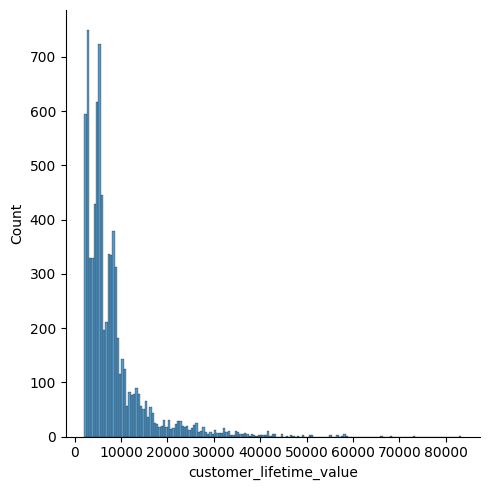

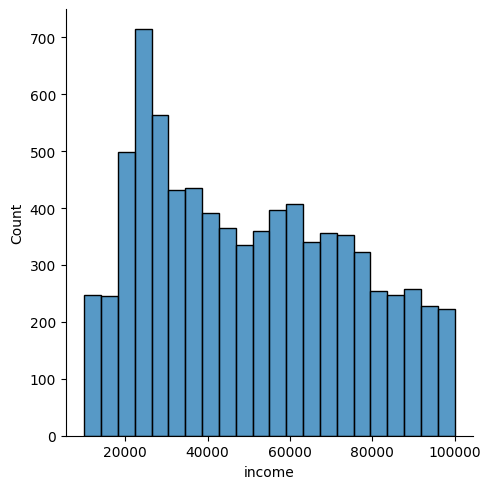

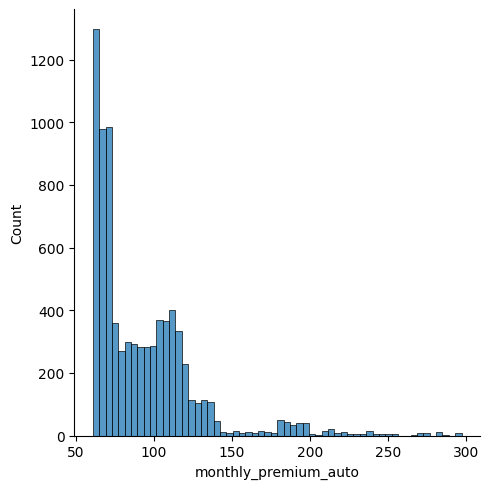

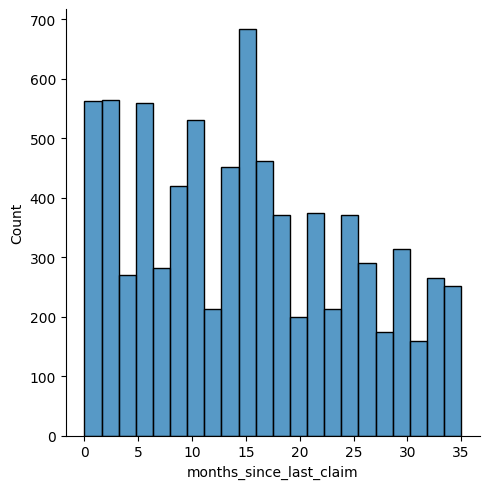

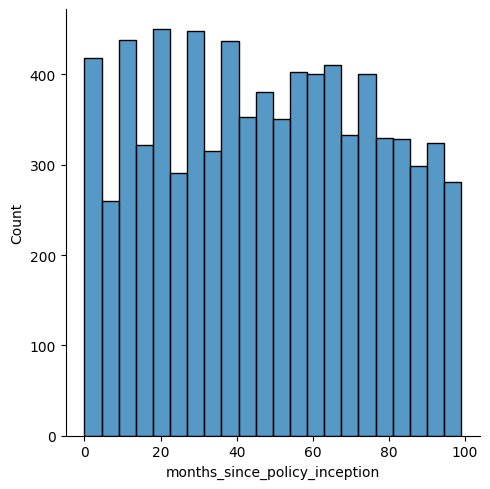

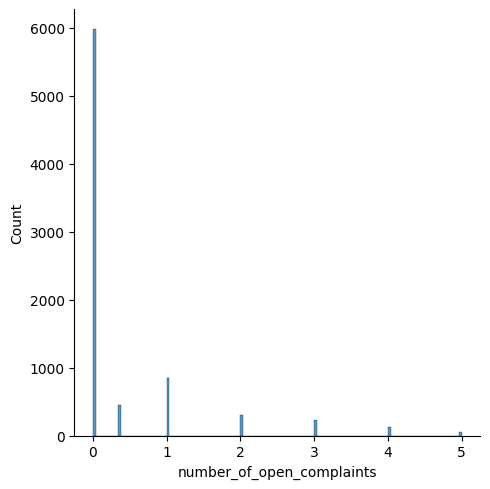

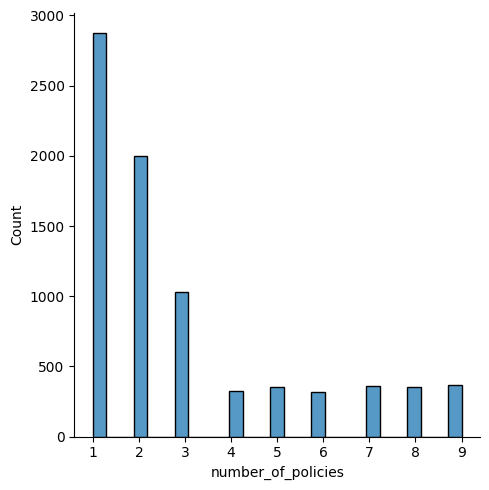

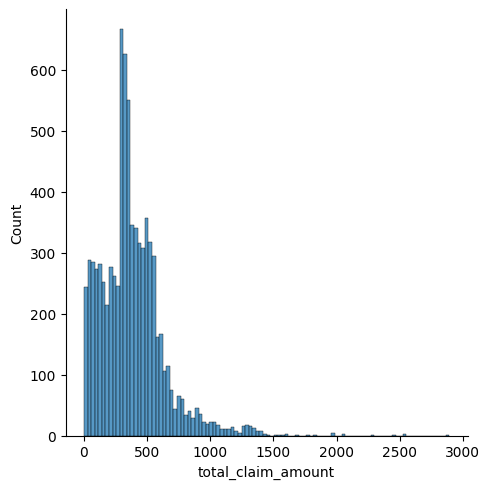

In [23]:
for column in numerical_data.columns:
    sns.displot(numerical_data[column])
plt.show()

### Use Matplotlib to construct histograms (I think this is the same)

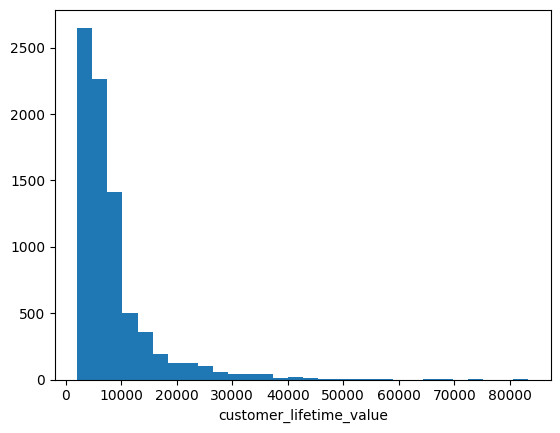

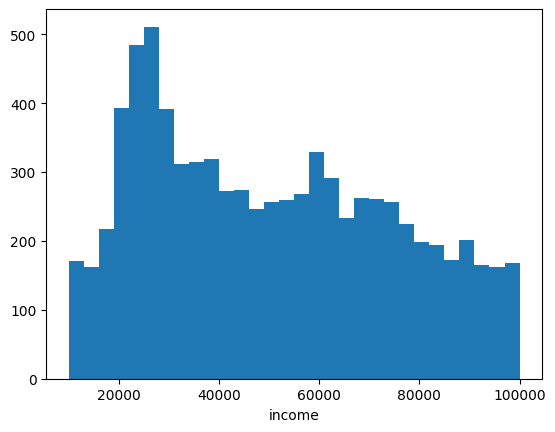

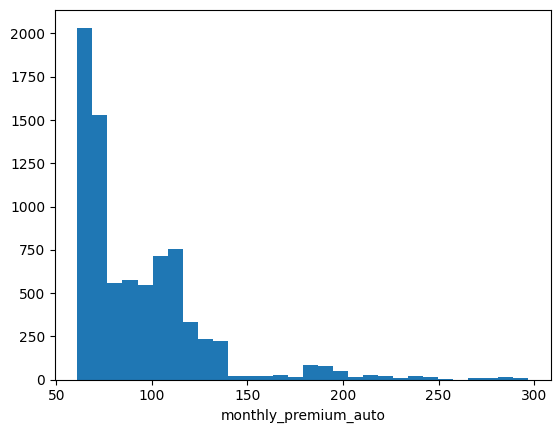

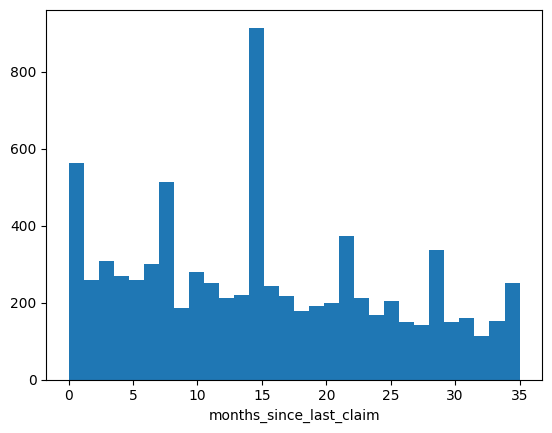

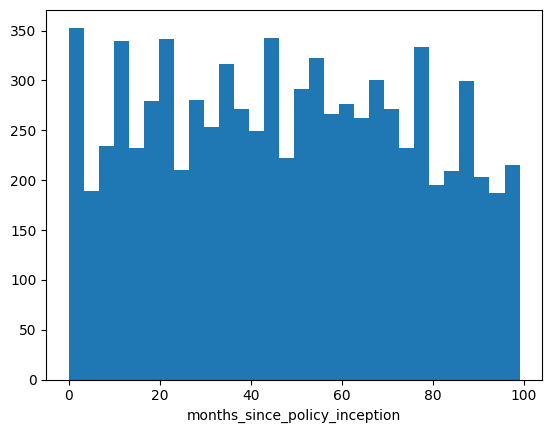

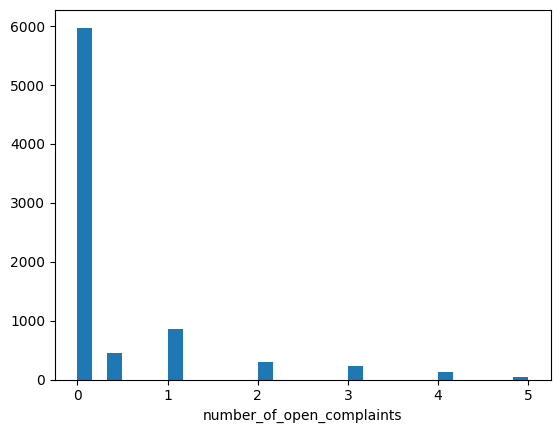

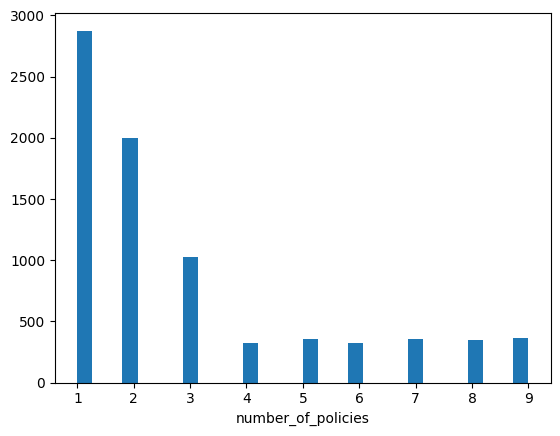

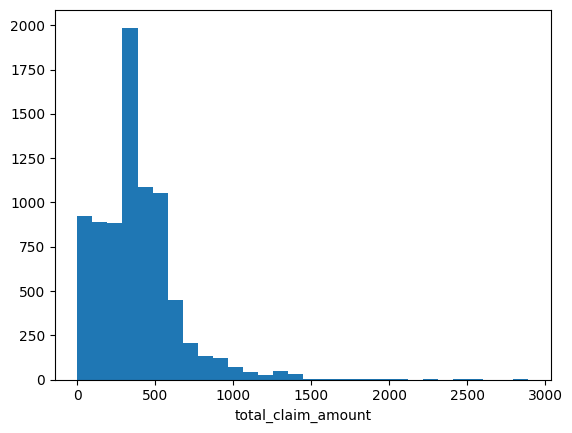

In [24]:
for column in numerical_data.columns:
    plt.figure()
    plt.hist(numerical_data[column],bins=30)
    plt.xlabel(column)
plt.show()

### Do the distributions for different numerical variables look like a normal distribution

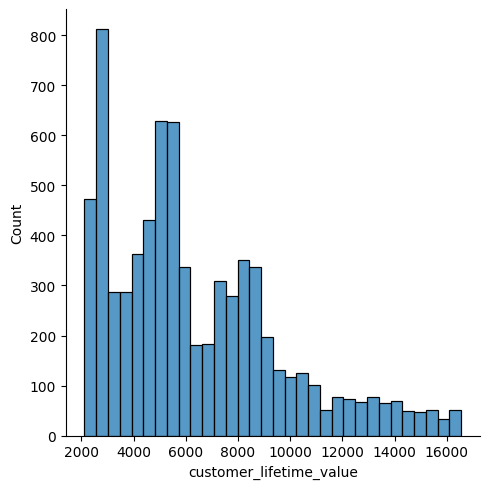

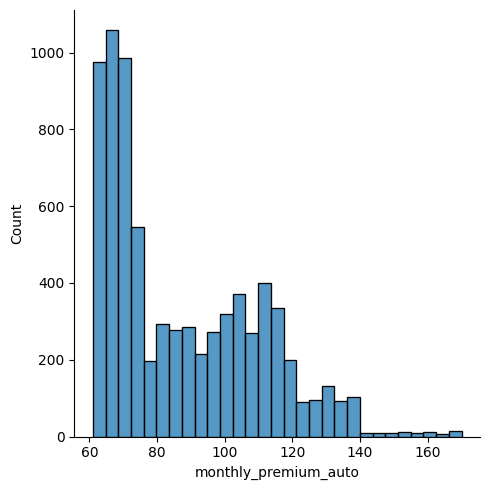

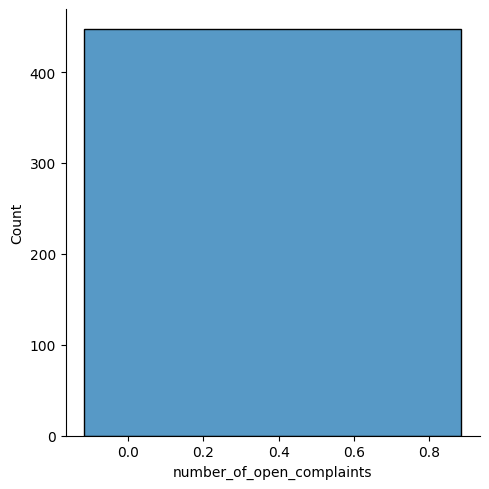

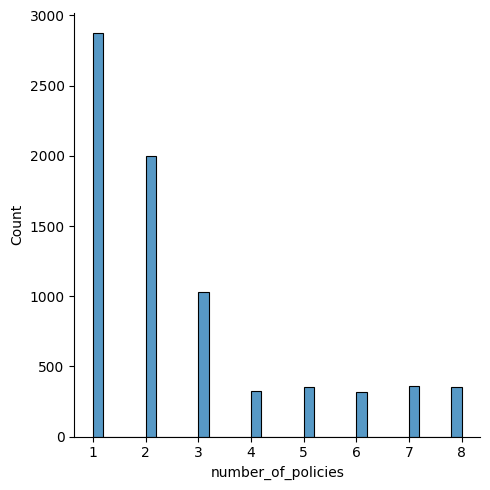

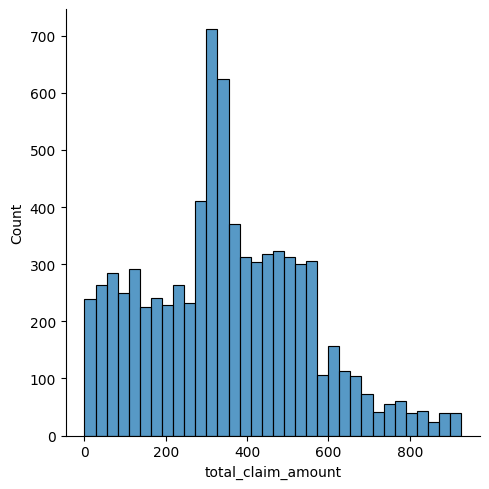

In [25]:
# I'll try to remove raw potencial outliers even if they're not,
# just to see if the distribution changes.
ratio = 1.5
non_normal = ['customer_lifetime_value', 'monthly_premium_auto', 'number_of_open_complaints', 'number_of_policies', 'total_claim_amount']

for column in non_normal:
    itqr = np.quantile(numerical_data[column],0.75)-np.quantile(numerical_data[column],0.25)
    lower_limit = max(0,np.quantile(numerical_data[column],0.25)-ratio*itqr)
    upper_limit = np.quantile(numerical_data[column],0.75)+ratio*itqr
    data_column = numerical_data[column][(numerical_data[column]>lower_limit) & (numerical_data[column]<upper_limit)]
    
    sns.displot(data_column)
plt.show()

# total-claim_amount looks more as a normal distribution now.

# The rest of columns doesn't. And number of open complaints is messed up
# because I already had a lot of zeros, and I fill the NA with the 
# mean which is close to zero. I think that by filling NAs, I'm making
# edge points look more outlier-ish? So in the end I removed too many
# legit points and I'm left with zeros, and the decimal points
# 0.~that come from filling NAs.

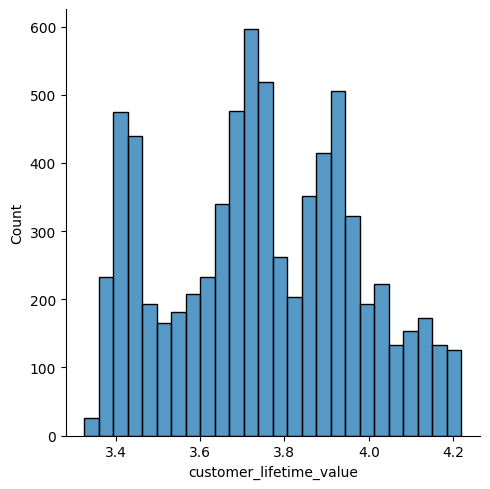

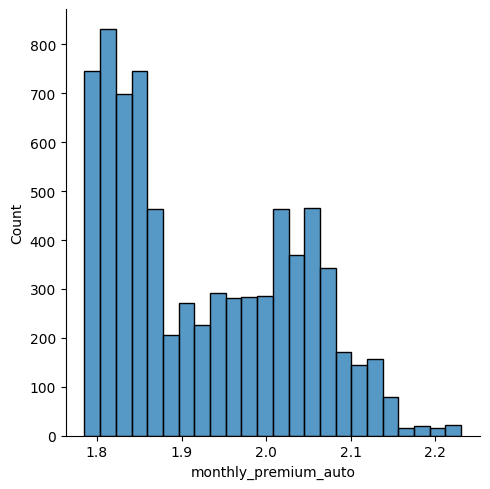

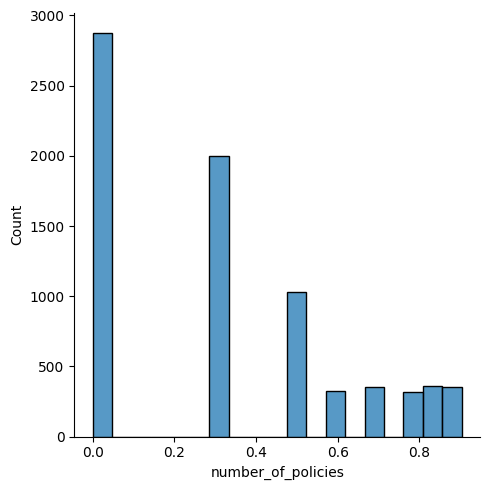

In [26]:
# -----------------------------------
# This is a copy of the cell above, but now I'm going to make it
# a log scale
ratio = 1.5
non_normal = ['customer_lifetime_value', 'monthly_premium_auto', 'number_of_policies']

def f_log(x):
    x = np.log10(x)
    if np.isfinite(x):
        return x
    else:
        return 0

for column in non_normal:
    itqr = np.quantile(numerical_data[column],0.75)-np.quantile(numerical_data[column],0.25)
    lower_limit = max(0,np.quantile(numerical_data[column],0.25)-ratio*itqr)
    upper_limit = np.quantile(numerical_data[column],0.75)+ratio*itqr
    data_column = numerical_data[column][(numerical_data[column]>lower_limit) & (numerical_data[column]<upper_limit)]
    
    sns.displot(data_column.apply(f_log))
plt.show()

# now customer_lifetime_value looks more normal though it has
# 3 bumps, so its either not normal or a combination of three normal dist.

### For the numerical variables, check the multicollinearity between the features. Please note that we will use the column total_claim_amount later as the target variable.

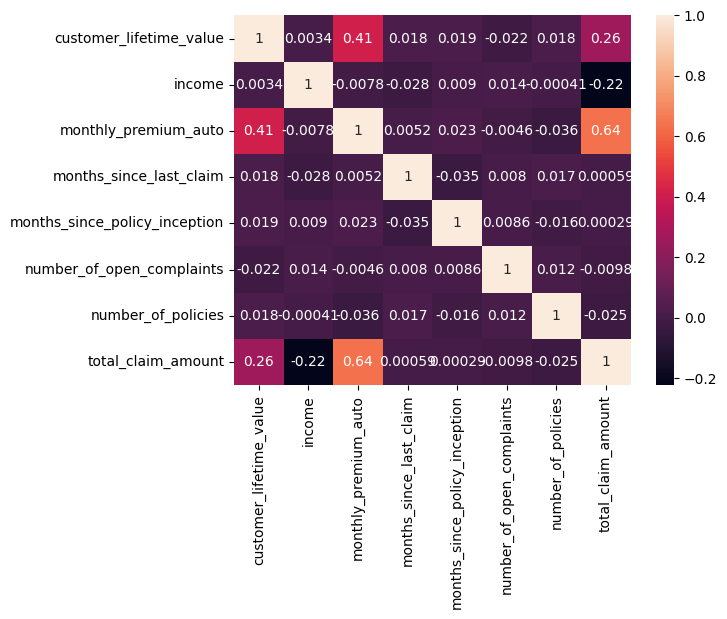

In [27]:
sns.heatmap(numerical_data.corr(), annot=True)
plt.show()
# It doesn't look as if we had dependant X columns.

# Round 5
### X-y split.

In [28]:
X = data.drop('total_claim_amount',axis=1)
y = data['total_claim_amount']

### Normalize (numerical).

In [29]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
X_num = X.select_dtypes(np.number)

transformer = MinMaxScaler().fit(X_num)
X_normalized = transformer.transform(X_num)
X_normalized = pd.DataFrame(X_normalized, columns=X_num.columns)
X_normalized.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_lifetime_value,7975.0,0.074231,0.086092,0.0,0.024384,0.045321,0.085710,1.0
income,7975.0,0.448836,0.269937,0.0,0.203732,0.423352,0.667854,1.0
monthly_premium_auto,7975.0,0.135854,0.146960,0.0,0.029661,0.093220,0.203390,1.0
months_since_last_claim,7975.0,0.431293,0.279559,0.0,0.200000,0.428571,0.657143,1.0
months_since_policy_inception,7975.0,0.483764,0.281648,0.0,0.242424,0.484848,0.717172,1.0
number_of_open_complaints,7975.0,0.076257,0.176065,0.0,0.000000,0.000000,0.076851,1.0
number_of_policies,7975.0,0.244216,0.299666,0.0,0.000000,0.125000,0.375000,1.0


# Round 6

### One Hot/Label (categorical).

In [30]:
from sklearn.preprocessing import OneHotEncoder
X_cat = X.select_dtypes(object)
X_cat = X_cat.drop(['customer'],axis=1)
encoder = OneHotEncoder(drop='first').fit(X_cat)
encoded = encoder.transform(X_cat).toarray()
onehot_encoded = pd.DataFrame(encoded,columns=encoder.get_feature_names_out(X_cat.columns))

### Concat DataFrames

In [31]:
X_ready = pd.concat([X_normalized,onehot_encoded],axis=1)

### Train-test split.

In [32]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Splitting model
X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.2, random_state=42)

### Apply linear regression. R2. MSE. RMSE. MAE.

In [33]:
# Training model with train data
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)

# Comparing values of Train and Test
# Checking the value of R^2
predictions = lm.predict(X_train)
print('The train R^2 is %1.3f.' %r2_score(y_train, predictions))
test_predictions = lm.predict(X_test)
print('The test R^2 is %1.3f.' %r2_score(y_test,test_predictions))

# Checking the value of MSE
print('\nThe train MSE is %i.' %mean_squared_error(y_train,predictions))
print('The test MSE is %i.' %mean_squared_error(y_test,test_predictions))

# Checking the value of RMSE
print('\nThe train MSE is %1.1f.' %np.sqrt(mean_squared_error(y_train,predictions)))
print('The test MSE is %1.1f.' %np.sqrt(mean_squared_error(y_test,test_predictions)))

# Checking the value of MAE
print('\nThe train MAE is %1.1f.'%mean_absolute_error(y_train,predictions))
print('The test MAE is %1.1f.'%mean_absolute_error(y_test,test_predictions))


The train R^2 is 0.805.
The test R^2 is 0.800.

The train MSE is 12805.
The test MSE is 11164.

The train MSE is 113.2.
The test MSE is 105.7.

The train MAE is 75.9.
The test MAE is 74.7.


# Round 7

In [ ]:
# -- Try to improve the linear regression model.

# I'll copy the code from before, but this time I will remove 
# unimportant numerical variables from the model

In [74]:
X = data.drop('total_claim_amount',axis=1)
y = data['total_claim_amount']

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
X_num = X.select_dtypes(np.number)
# new ---------------------------------------- #
# I'll only choose numerical variables with a decent correlation
X_num=X_num[['customer_lifetime_value','income','monthly_premium_auto']]
# -------------------------------------------- #

transformer = MinMaxScaler().fit(X_num)
X_normalized = transformer.transform(X_num)
X_normalized = pd.DataFrame(X_normalized, columns=X_num.columns)

from sklearn.preprocessing import OneHotEncoder
X_cat = X.select_dtypes(object)
# new ---------------------------------------- #
# I have tried removing every categorical attribute and the only
# whose absence affects the model is location_code, so I keep it.
X_cat = X_cat[['location_code']]
# -------------------------------------------- #

encoder = OneHotEncoder(drop='first').fit(X_cat)
encoded = encoder.transform(X_cat).toarray()
onehot_encoded = pd.DataFrame(encoded,columns=encoder.get_feature_names_out(X_cat.columns))

X_ready = pd.concat([X_normalized,onehot_encoded],axis=1)

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Splitting model
X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.2, random_state=42)

# Training model with train data
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)

# Comparing values of Train and Test
# Checking the value of R^2
predictions = lm.predict(X_train)
print('The train R^2 is %1.3f.' %r2_score(y_train, predictions))
test_predictions = lm.predict(X_test)
print('The test R^2 is %1.3f.' %r2_score(y_test,test_predictions))

# Checking the value of MSE
print('\nThe train MSE is %i.' %mean_squared_error(y_train,predictions))
print('The test MSE is %i.' %mean_squared_error(y_test,test_predictions))

# Checking the value of RMSE
print('\nThe train S.MSE is %1.1f.' %np.sqrt(mean_squared_error(y_train,predictions)))
print('The test S.MSE is %1.1f.' %np.sqrt(mean_squared_error(y_test,test_predictions)))

# Checking the value of MAE
print('\nThe train MAE is %1.1f.'%mean_absolute_error(y_train,predictions))
print('The test MAE is %1.1f.'%mean_absolute_error(y_test,test_predictions))

print("\nThe results are practically the same but with only 3 numerical variables and 1 categorical, so I would say the model was improved because it is more simple.")

The train R^2 is 0.799.
The test R^2 is 0.802.

The train MSE is 13163.
The test MSE is 11009.

The train S.MSE is 114.7.
The test S.MSE is 104.9.

The train MAE is 77.0.
The test MAE is 75.4.

The results are practically the same but with only 3 numerical variables and 1 categorical, so I would say the model was improved because it is more simple.


# Final round

The data teach us that our target **Total Claim Amount** is correlated with only 4 of our data attributes: *Customer lifetime value*, *Income*, *Monthly premium auto* and *Location code*. The model has a **R2 of 0.799** and it had the same accuracy with our test data (**R2 = 0.802**).

Maybe the model could be improved by checking the correlation of our original variables but transformed by a function (square, square root, etc), and introducing those with important correlation to the model.